## Character-level recurrent sequence-to-sequence model

Example from https://keras.io/examples/nlp/lstm_seq2seq/  
Older post https://blog.keras.io/a-ten-minute-introduction-to-sequence-to-sequence-learning-in-keras.html

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

import numpy as np
import pandas as pd
import pydot as pyd
from itertools import chain

import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow import keras 
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import LSTM, GRU, Dense, RepeatVector, TimeDistributed, Input, BatchNormalization, \
    multiply, concatenate, Flatten, Activation, dot
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)

In [3]:
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 8)

In [4]:
with np.load('data/ncbi_02/dataset.npz', allow_pickle = True) as data:
    encoder_input_data = data['encoder_input_data']
    decoder_input_data = data['decoder_input_data']
    decoder_target_data = data['decoder_target_data']
    token_index = data['token_index'].tolist()

In [5]:
print(encoder_input_data.shape)
print(decoder_input_data.shape)
print(decoder_target_data.shape)
print(token_index)

(4368, 3822, 4)
(4368, 3822, 4)
(4368, 3822, 4)
{'A': 0, 'C': 1, 'G': 2, 'T': 3}


In [6]:
X_data = encoder_input_data[:20]
Y_data = decoder_input_data[:20]
print("X_data", X_data.shape)
print("Y_data", Y_data.shape)

X_data (20, 3822, 4)
Y_data (20, 3822, 4)


In [7]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 15275402716124757984
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 7050428416
locality {
  bus_id: 1
  links {
    link {
      device_id: 1
      type: "StreamExecutor"
      strength: 1
    }
  }
}
incarnation: 10724958437785455680
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1080, pci bus id: 0000:01:00.0, compute capability: 6.1"
, name: "/device:GPU:1"
device_type: "GPU"
memory_limit: 7741702144
locality {
  bus_id: 1
  links {
    link {
      type: "StreamExecutor"
      strength: 1
    }
  }
}
incarnation: 15027274830728867675
physical_device_desc: "device: 1, name: NVIDIA GeForce GTX 1080, pci bus id: 0000:02:00.0, compute capability: 6.1"
]


## Construct model

In [8]:
n_hidden = 32

In [9]:
input_train = Input(shape=(X_data.shape[1], X_data.shape[2]))
output_train = Input(shape=(Y_data.shape[1], Y_data.shape[2]))
print(input_train)
print(output_train)

KerasTensor(type_spec=TensorSpec(shape=(None, 3822, 4), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")
KerasTensor(type_spec=TensorSpec(shape=(None, 3822, 4), dtype=tf.float32, name='input_2'), name='input_2', description="created by layer 'input_2'")


In [10]:
encoder_stack_h, encoder_last_h = GRU(
    n_hidden, dropout = 0.05, recurrent_dropout = 0.05,
    return_sequences = True, return_state = True)(input_train)
print(encoder_stack_h)
print(encoder_last_h)

KerasTensor(type_spec=TensorSpec(shape=(None, 3822, 32), dtype=tf.float32, name=None), name='gru/transpose_1:0', description="created by layer 'gru'")
KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='gru/while:4', description="created by layer 'gru'")


In [11]:
encoder_last_h = BatchNormalization(momentum = 0.6)(encoder_last_h)
decoder_input = RepeatVector(Y_data.shape[1])(encoder_last_h)
print(decoder_input)

KerasTensor(type_spec=TensorSpec(shape=(None, 3822, 32), dtype=tf.float32, name=None), name='repeat_vector/Tile:0', description="created by layer 'repeat_vector'")


In [12]:
decoder_stack_h = GRU(n_hidden, dropout = 0.01, recurrent_dropout = 0.01,
 return_state = False, return_sequences = True)(
 decoder_input, initial_state = encoder_last_h)
print(decoder_stack_h)

KerasTensor(type_spec=TensorSpec(shape=(None, 3822, 32), dtype=tf.float32, name=None), name='gru_1/transpose_1:0', description="created by layer 'gru_1'")


In [13]:
attention = dot([decoder_stack_h, encoder_stack_h], axes = [2, 2])
attention = Activation('softmax')(attention)
print(attention)

KerasTensor(type_spec=TensorSpec(shape=(None, 3822, 3822), dtype=tf.float32, name=None), name='activation/Softmax:0', description="created by layer 'activation'")


In [14]:
context = dot([attention, encoder_stack_h], axes = [2,1])
context = BatchNormalization(momentum = 0.6)(context)
print(context)

KerasTensor(type_spec=TensorSpec(shape=(None, 3822, 32), dtype=tf.float32, name=None), name='batch_normalization_1/batchnorm/add_1:0', description="created by layer 'batch_normalization_1'")


In [15]:
decoder_combined_context = concatenate([context, decoder_stack_h])
print(decoder_combined_context)

KerasTensor(type_spec=TensorSpec(shape=(None, 3822, 64), dtype=tf.float32, name=None), name='concatenate/concat:0', description="created by layer 'concatenate'")


In [16]:
out = TimeDistributed(Dense(Y_data.shape[2], activation = "softmax"))(decoder_combined_context)
print(out)

KerasTensor(type_spec=TensorSpec(shape=(None, 3822, 4), dtype=tf.float32, name=None), name='time_distributed/Reshape_1:0', description="created by layer 'time_distributed'")


In [17]:
model = Model(inputs = input_train, outputs = out)
opt = keras.optimizers.Adam(learning_rate = 0.01, clipnorm = 1)
model.compile(loss = 'categorical_crossentropy', optimizer = opt, metrics = ['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 3822, 4)]    0                                            
__________________________________________________________________________________________________
gru (GRU)                       [(None, 3822, 32), ( 3648        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32)           128         gru[0][1]                        
__________________________________________________________________________________________________
repeat_vector (RepeatVector)    (None, 3822, 32)     0           batch_normalization[0][0]        
______________________________________________________________________________________________

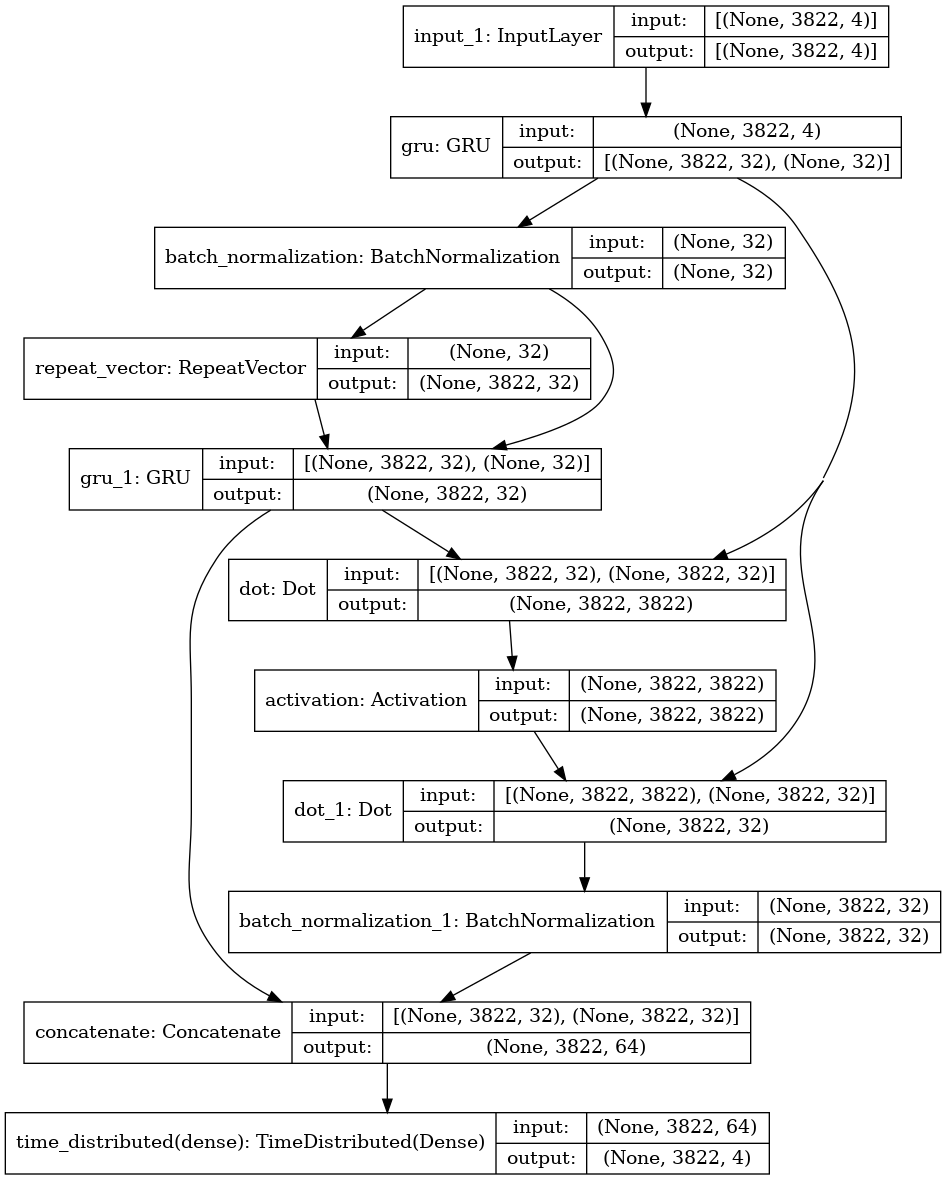

In [18]:
keras.utils.plot_model(model, to_file = 'model_plot.png', show_shapes = True, show_layer_names = True)

## Train model

In [19]:
batch_size = 16      # Batch size for training.
patience = 10        # Patience for EarlyStop
epochs = 1000        # Number of epochs to train for.

In [20]:
es = EarlyStopping(monitor = 'val_loss', mode = 'min', patience = patience, restore_best_weights = True)
history = model.fit(X_data, Y_data, validation_split = 0.2, 
                    epochs = epochs, verbose = 1, callbacks = [ es ], 
                    batch_size = batch_size)
train_mae = history.history['accuracy']
valid_mae = history.history['val_accuracy']

Epoch 1/1000
1/1 [==============================] - 10s 10s/step - loss: 1.3995 - accuracy: 0.2696 - val_loss: 1.3658 - val_accuracy: 0.3323
Epoch 2/1000
1/1 [==============================] - 7s 7s/step - loss: 1.3744 - accuracy: 0.3254 - val_loss: 1.3570 - val_accuracy: 0.3323
Epoch 3/1000
1/1 [==============================] - 7s 7s/step - loss: 1.3768 - accuracy: 0.3185 - val_loss: 1.3549 - val_accuracy: 0.2945
Epoch 4/1000
1/1 [==============================] - 7s 7s/step - loss: 1.3541 - accuracy: 0.3326 - val_loss: 1.3551 - val_accuracy: 0.2945
Epoch 5/1000
1/1 [==============================] - 7s 7s/step - loss: 1.3552 - accuracy: 0.3305 - val_loss: 1.3558 - val_accuracy: 0.2945
Epoch 6/1000
1/1 [==============================] - 7s 7s/step - loss: 1.4411 - accuracy: 0.2991 - val_loss: 1.3562 - val_accuracy: 0.3325
Epoch 7/1000
1/1 [==============================] - 7s 7s/step - loss: 1.3599 - accuracy: 0.3326 - val_loss: 1.3574 - val_accuracy: 0.3325
Epoch 8/1000
1/1 [=======

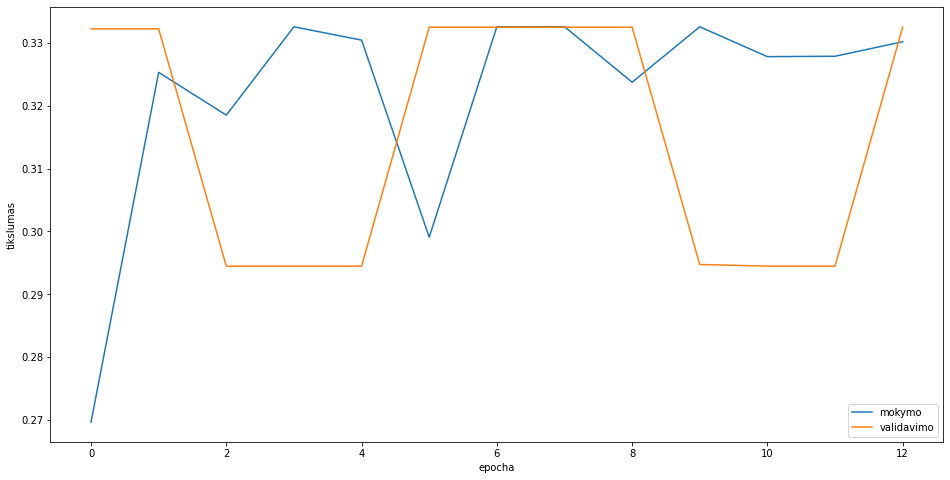

In [21]:
plt.plot(history.history['accuracy'], label = 'mokymo')
plt.plot(history.history['val_accuracy'], label = 'validavimo')
plt.ylabel('tikslumas')
plt.xlabel('epocha')
plt.legend()
plt.show()

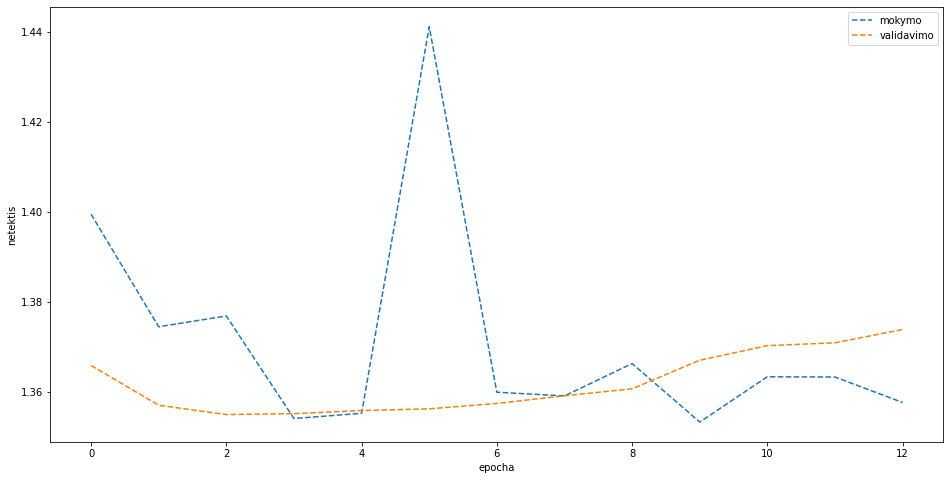

In [22]:
plt.plot(history.history['loss'], '--', label = 'mokymo')
plt.plot(history.history['val_loss'], '--', label = 'validavimo')
plt.ylabel('netektis')
plt.xlabel('epocha')
plt.legend()
plt.show()

In [14]:
model.save("data/ncbi_02/model_gru_bi_256")

2021-10-07 10:59:42.345759: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: data/ncbi_02/model_gru_bi_256/assets


INFO:tensorflow:Assets written to: data/ncbi_02/model_gru_bi_256/assets
